# Modelo

- [Cargue de datos](#Cargue-Datos)
- [Reglas establecidas](#Reglas)
- Modelo
    - [Regresión Logistica](#Regresion-Logistica)
    - [RandomForest](#RandomForest)
- [Justicia](#Justicia)
    - [Genero](#Genero)
    - [Ciudad Residencia](#Ciudad-Residencia)
    - [Estrato](#Estrato)
- [Selección Modelo](#Seleccion-Modelo)
    - Generar joblib

## Librería

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, confusion_matrix, classification_report,mean_absolute_error, mean_squared_error, r2_score,roc_curve, auc, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression,LogisticRegression

import joblib
import warnings
import sys
import os
import random

# Imprimir el texto en formato Markdown
from IPython.display import Markdown


In [5]:
# configuración
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.float_format', '{:.2f}'.format)  # 2 decimales
pd.set_option('expand_frame_repr', False)
np.set_printoptions(threshold=sys.maxsize)

In [6]:
# Establecer la semilla general
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

In [7]:
# Función para formatear a dos decimales
def decimal_formatter(x, _):
    return f"{x:,.2f}" 

def decimal_formatter2(x):
    return f"{x:,.2f}" 

In [8]:
def calculate_target(row):
    """
    Función para definir el valor de target de acuerdo a las reglas
    
    :param 
        row: Columna de la cual se revisa el target
    :return 
        target: Valor 0, si corresponde a deserción; Valor 1 si mantiene sus estudios
    """
    target=0
    if (row['SITUACION_ACTUAL'] == 'EXCLUIDO NO RENOVACION DE MATRICULA' or row["SITUACION_ACTUAL"]=='RETIRO DEFINITIVO' or row["SITUACION_ACTUAL"]=='EXCLUIDO CANCELACION SEMESTRE' ) and  (row['CATEGORIA_ACTUAL'] != "CONTINUIDAD ACADEMICA - EGRESADO") :
        target=0
    else:
        target=1
    
    return target

## Cargue Datos
([Volver al Inicio](#Modelo))

In [10]:
# Carga de datos
data = pd.read_csv('../stage/clean.csv', sep=",", encoding='utf-8')

In [11]:
# Visualización de datos
data.head()

,ESTRATO,SEMESTRE,PROMEDIOSEMESTRE,EDAD2,PROGRAMA,GENERO,CIUDADRESIDENCIA,CIUDADNACIMIENTO,target
0,3.00,8,3.90,22,4,1,23,47,1
1,3.00,8,4.50,27,4,0,23,47,1
2,3.00,8,4.00,22,4,0,23,119,1
3,3.00,8,4.80,26,4,0,23,47,1
4,3.00,7,4.20,28,4,0,23,47,1


In [12]:
# Visualización de datos
data.head()

,ESTRATO,SEMESTRE,PROMEDIOSEMESTRE,EDAD2,PROGRAMA,GENERO,CIUDADRESIDENCIA,CIUDADNACIMIENTO,target
0,3.00,8,3.90,22,4,1,23,47,1
1,3.00,8,4.50,27,4,0,23,47,1
2,3.00,8,4.00,22,4,0,23,119,1
3,3.00,8,4.80,26,4,0,23,47,1
4,3.00,7,4.20,28,4,0,23,47,1


In [13]:
# dimension datasets
print(f'Dimensiones del dataset data : {data.shape[0]} registros, {data.shape[1]} columnas')

Dimensiones del dataset data : 9096 registros, 9 columnas


In [14]:
# Revisón de campos vacíos/nulos
nulos_y_tipos = pd.DataFrame({
    'nulos': data.isnull().sum(),
    'tipo_dato': data.dtypes
})
nulos_y_tipos

,nulos,tipo_dato
ESTRATO,6,float64
SEMESTRE,0,int64
PROMEDIOSEMESTRE,0,float64
EDAD2,0,int64
PROGRAMA,0,int64
GENERO,0,int64
CIUDADRESIDENCIA,0,int64
CIUDADNACIMIENTO,0,int64
target,0,int64


In [15]:
# Estadisticas del dataset
data.describe(include='all')

,ESTRATO,SEMESTRE,PROMEDIOSEMESTRE,EDAD2,PROGRAMA,GENERO,CIUDADRESIDENCIA,CIUDADNACIMIENTO,target
count,9090.00,9096.00,9096.00,9096.00,9096.00,9096.00,9096.00,9096.00,9096.00
mean,2.30,5.34,3.71,23.90,2.45,0.58,48.96,91.70,0.86
std,0.98,2.99,1.01,5.62,2.00,0.49,45.62,76.14,0.34
min,1.00,1.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,2.00,3.40,21.00,1.00,0.00,23.00,47.00,1.00
50%,2.00,6.00,4.00,23.00,2.00,1.00,23.00,47.00,1.00
75%,3.00,8.00,4.40,25.00,4.00,1.00,70.00,126.00,1.00
max,6.00,10.00,5.00,66.00,7.00,1.00,174.00,294.00,1.00


In [16]:
data = data.dropna()
# Revisón de campos vacíos/nulos
nulos_y_tipos = pd.DataFrame({
    'nulos': data.isnull().sum(),
    'tipo_dato': data.dtypes
})
nulos_y_tipos

,nulos,tipo_dato
ESTRATO,0,float64
SEMESTRE,0,int64
PROMEDIOSEMESTRE,0,float64
EDAD2,0,int64
PROGRAMA,0,int64
GENERO,0,int64
CIUDADRESIDENCIA,0,int64
CIUDADNACIMIENTO,0,int64
target,0,int64


In [17]:
data.duplicated().sum()

0

## Reglas
([Volver al Inicio](#Modelo))

Como parte de reglas establecidas, se menciona que se deben excluir el nivel de formación `Especialización`

Así mismo, de acuerdo con ENDEPORTE la forma de clasificar la deserción corresponde a lo siguiente:

![Reglas de Deserción](../../docs/regla.png)

Con base a lo anterior, se procede a calcular la columna `target` correspondiente a la deserción con la cual:
- Valor `0` corresponde a estudiantes que desertan
- Valor `1` corresponde a estudiantes que permanecen en sus estudios




In [22]:
data.head()

,ESTRATO,SEMESTRE,PROMEDIOSEMESTRE,EDAD2,PROGRAMA,GENERO,CIUDADRESIDENCIA,CIUDADNACIMIENTO,target
0,3.00,8,3.90,22,4,1,23,47,1
1,3.00,8,4.50,27,4,0,23,47,1
2,3.00,8,4.00,22,4,0,23,119,1
3,3.00,8,4.80,26,4,0,23,47,1
4,3.00,7,4.20,28,4,0,23,47,1


In [23]:
df = data.copy()

## Regresion Logistica
([Volver al Inicio](#Modelo))

In [25]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=['target'])  # Excluir la columna target
y = df['target']  # Variable objetivo

# Dividir el conjunto en train + validation (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value, stratify=y)

# Dividir el conjunto de train en train (80% de train) y validation (20% de train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed_value, stratify=y_train)

In [26]:
# Confirmar las proporciones
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 5817
Tamaño del conjunto de validación: 1455
Tamaño del conjunto de prueba: 1818


In [27]:
# Crear escalador y SMOTE
scaler = StandardScaler()
smote = SMOTE(random_state=seed_value)

# --- Random Forest (sin escalado, pero con SMOTE) ---
x_rf_train, y_rf_train = smote.fit_resample(X_train, y_train)
x_rf_val, y_rf_val = X_val, y_val  # Sin escalado
x_rf_test, y_rf_test = X_test, y_test  # Sin escalado

# --- Regresión Logística (con escalado y SMOTE) ---
# Escalado en train, validation y test
x_lr_train_scaled = scaler.fit_transform(X_train)
x_lr_val_scaled = scaler.transform(X_val)
x_lr_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE al conjunto de entrenamiento escalado
x_lr_train, y_lr_train = smote.fit_resample(x_lr_train_scaled, y_train)

# Guardar conjuntos de validación y prueba escalados
x_lr_val, y_lr_val = x_lr_val_scaled, y_val
x_lr_test, y_lr_test = x_lr_test_scaled, y_test

# Confirmar distribuciones después de SMOTE
print("Distribución después de SMOTE para Random Forest (Train):")
print(pd.Series(y_rf_train).value_counts(normalize=True) * 100)
print("\nDistribución después de SMOTE para Regresión Logística (Train):")
print(pd.Series(y_lr_train).value_counts(normalize=True) * 100)

print("\nConjuntos de datos preparados para Random Forest y Regresión Logística.")

Distribución después de SMOTE para Random Forest (Train):
target
1   50.00
0   50.00
Name: proportion, dtype: float64

Distribución después de SMOTE para Regresión Logística (Train):
target
1   50.00
0   50.00
Name: proportion, dtype: float64

Conjuntos de datos preparados para Random Forest y Regresión Logística.


In [28]:
# Verificar la distribución de la variable target en el conjunto original
print(data['target'].value_counts(normalize=True))

target
1   0.86
0   0.14
Name: proportion, dtype: float64


In [29]:
regression = LogisticRegression()

In [30]:
regression.fit(x_lr_train, y_lr_train)

LogisticRegression()

In [31]:
y_pred = regression.predict(x_lr_test)

In [32]:
# Precisión del modelo
accuracy_lr = accuracy_score(y_lr_test, y_pred)
print(f"Precisión: {accuracy_lr:.2f}")

Precisión: 0.69



Matriz de confusión:


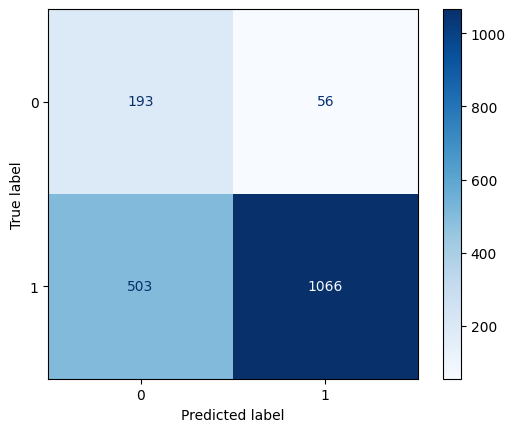

In [33]:
# Matriz de confusión
print("\nMatriz de confusión:")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_lr_test, y_pred)

# Mostrar la matriz de confusión 
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')  
plt.show()

In [34]:
# Reporte de clasificación
print("\nReporte de clasificación:")
report = classification_report(y_lr_test, y_pred, output_dict=True)
reportF = classification_report(y_lr_test, y_pred)
print(reportF)

precision_0 = report['0']['precision']
recall_0 = report['0']['recall']
f1_0 = report['0']['f1-score']
support_0 = report['0']['support']

precision_1 = report['1']['precision']
recall_1 = report['1']['recall']
f1_1 = report['1']['f1-score']
support_1 = report['1']['support']

accuracy = report['accuracy']
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.28      0.78      0.41       249
           1       0.95      0.68      0.79      1569

    accuracy                           0.69      1818
   macro avg       0.61      0.73      0.60      1818
weighted avg       0.86      0.69      0.74      1818



In [35]:
markdown_text = f"""
Con lo anterior, se evidencia:

**Precisión**
- Para la clase 0 (deserción), la precisión es {decimal_formatter2(precision_0)}. Esto significa que, de todas las veces que el modelo predijo que un estudiante desertaría (predicción de "0"), el {decimal_formatter2(precision_0 * 100)}% de esas predicciones fueron correctas.
- Para la clase 1 (no deserción), la precisión es {decimal_formatter2(precision_1)}. Esto significa que, de todas las veces que el modelo predijo que un estudiante no desertaría (predicción de "1"), el {decimal_formatter2(precision_1 * 100)}% de esas predicciones fueron correctas.

**Recall**
- Para la clase 0 (deserción), el recall es {decimal_formatter2(recall_0)}. Esto indica que el modelo identificó correctamente el {decimal_formatter2(recall_0*100)}% de los estudiantes que realmente desertaron.
- Para la clase 1 (no deserción), el recall es {decimal_formatter2(recall_1)}. Esto indica que el modelo identificó correctamente el {decimal_formatter2(recall_1*100)}% de los estudiantes que NO desertaron.

**F1-Score**
- Para la clase 0 (deserción), el F1-score es {decimal_formatter2(f1_0)}. 
- Para la clase 1 (no deserción), el F1-score es {decimal_formatter2(f1_1)}. 
"""

In [36]:
display(Markdown(markdown_text))


Con lo anterior, se evidencia:

**Precisión**
- Para la clase 0 (deserción), la precisión es 0.28. Esto significa que, de todas las veces que el modelo predijo que un estudiante desertaría (predicción de "0"), el 27.73% de esas predicciones fueron correctas.
- Para la clase 1 (no deserción), la precisión es 0.95. Esto significa que, de todas las veces que el modelo predijo que un estudiante no desertaría (predicción de "1"), el 95.01% de esas predicciones fueron correctas.

**Recall**
- Para la clase 0 (deserción), el recall es 0.78. Esto indica que el modelo identificó correctamente el 77.51% de los estudiantes que realmente desertaron.
- Para la clase 1 (no deserción), el recall es 0.68. Esto indica que el modelo identificó correctamente el 67.94% de los estudiantes que NO desertaron.

**F1-Score**
- Para la clase 0 (deserción), el F1-score es 0.41. 
- Para la clase 1 (no deserción), el F1-score es 0.79. 


In [37]:
print('MAE')
print("Train:", mean_absolute_error(y_lr_train, regression.predict(x_lr_train)))
print("Test :", mean_absolute_error(y_lr_test, regression.predict(x_lr_test)))

MAE
Train: 0.25219036240541615
Test : 0.30748074807480746


In [38]:
print('RMSE')
print("Train:", np.sqrt(mean_squared_error(y_lr_train, regression.predict(x_lr_train))))
print("Test :", np.sqrt(mean_squared_error(y_lr_test, regression.predict(x_lr_test))))

RMSE
Train: 0.5021855856209099
Test : 0.5545094661724067


AUC-ROC: 0.79


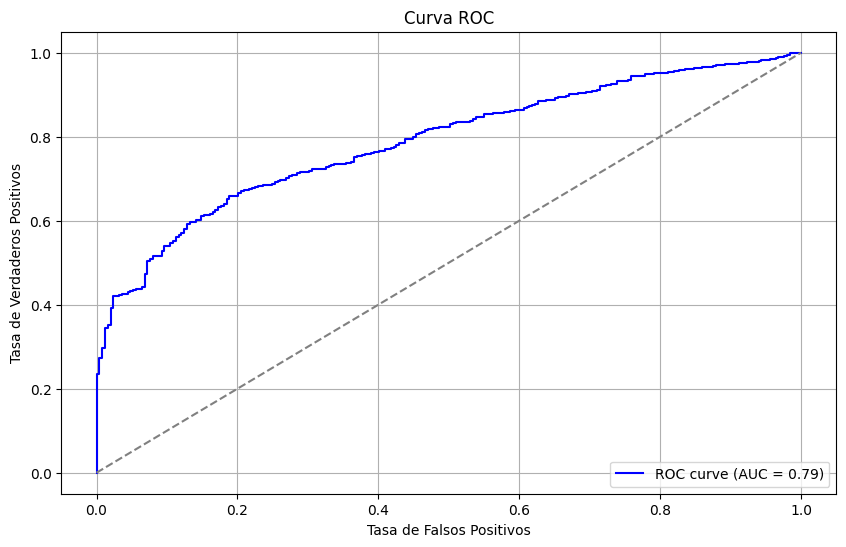

In [39]:
y_prob = regression.predict_proba(x_lr_test)[:, 1]  # Tomamos la probabilidad de la clase "1" (no deserción)
# Calcular el AUC-ROC
auc = roc_auc_score(y_lr_test, y_prob)
print(f"AUC-ROC: {auc:.2f}")

# Calcular los valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_lr_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## RandomForest
([Volver al Inicio](#Modelo))

In [41]:
# Verificar la distribución en los subconjuntos de entrenamiento, validación y prueba
print('Distribución en el conjunto de entrenamiento (SMOTE aplicado):')
print(y_rf_train.value_counts(normalize=True))

print('\nDistribución en el conjunto de validación:')
print(y_rf_val.value_counts(normalize=True))

print('\nDistribución en el conjunto de prueba:')
print(y_rf_test.value_counts(normalize=True))

Distribución en el conjunto de entrenamiento (SMOTE aplicado):
target
1   0.50
0   0.50
Name: proportion, dtype: float64

Distribución en el conjunto de validación:
target
1   0.86
0   0.14
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
target
1   0.86
0   0.14
Name: proportion, dtype: float64


In [42]:
# Crear el modelo (por ejemplo, RandomForest)
rf = RandomForestClassifier(random_state=seed_value)

# Entrenar el modelo
rf.fit(x_rf_train, y_rf_train)

# Hacer predicciones en el conjunto de test
y_pred = rf.predict(x_rf_test)

# Calcular la precisión general del modelo
accuracy_rf = accuracy_score(y_rf_test, y_pred)
print(f"Precisión general del modelo: {decimal_formatter2(accuracy_rf)}")


Precisión general del modelo: 0.84



Matriz de confusión:


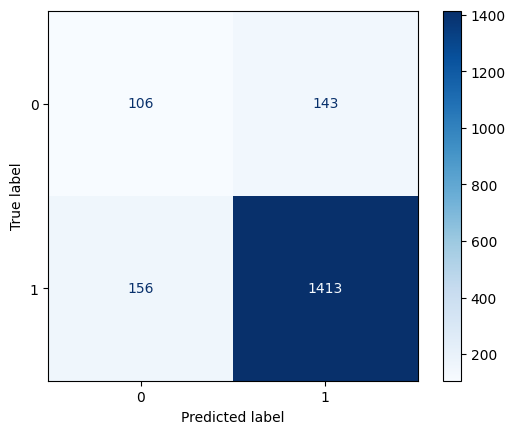

In [43]:
y_rf_pred = rf.predict(x_rf_test)

# Matriz de confusión
print("\nMatriz de confusión:")
# Calcular la matriz de confusión
conf_matrix_rf = confusion_matrix(y_rf_test, y_rf_pred)

# Mostrar la matriz de confusión 
disp = ConfusionMatrixDisplay(conf_matrix_rf)
disp.plot(cmap='Blues')  
plt.show()

In [44]:
# Reporte de clasificación
print("\nReporte de clasificación:")
report = classification_report(y_rf_test, y_rf_pred, output_dict=True)
reportF = classification_report(y_rf_test, y_rf_pred)
print(reportF)

rf_precision_0 = report['0']['precision']
rf_recall_0 = report['0']['recall']
rf_f1_0 = report['0']['f1-score']
rf_support_0 = report['0']['support']

rf_precision_1 = report['1']['precision']
rf_recall_1 = report['1']['recall']
rf_f1_1 = report['1']['f1-score']
rf_support_1 = report['1']['support']

rf_accuracy = report['accuracy']
rf_macro_avg = report['macro avg']
rf_weighted_avg = report['weighted avg']


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.40      0.43      0.41       249
           1       0.91      0.90      0.90      1569

    accuracy                           0.84      1818
   macro avg       0.66      0.66      0.66      1818
weighted avg       0.84      0.84      0.84      1818



In [45]:
print('MAE')
print("Train:", decimal_formatter2(mean_absolute_error(y_rf_train, rf.predict(x_rf_train))))
print("Test :", decimal_formatter2(mean_absolute_error(y_rf_test, rf.predict(x_rf_test))))

MAE
Train: 0.00
Test : 0.16


In [46]:
print('RMSE')
print("Train:", decimal_formatter2(np.sqrt(mean_squared_error(y_rf_train, regression.predict(x_rf_train)))))
print("Test :", decimal_formatter2(np.sqrt(mean_squared_error(y_rf_test , regression.predict(x_rf_test )))))

RMSE
Train: 0.71
Test : 0.37


## Justicia
([Volver al Inicio](#Modelo))

Las medidas de justicia permiten evaluar si un modelo predice un resultado para todos de manera igualitaria para todos los valores de un atributo sensible; dentro de los datos se identificarion 3 atributos para aplicar justicia (Fairness):
- [Genero](#Genero)
- [Ciudad Residencia](#Ciudad-Residencia)
- [Estrato](#Estrato)

### Genero
([Volver al Inicio](#Modelo))

Para el campo de GENERO los valores corresponde a:
- `0` Femenio
- `1` Masculino

In [50]:
model = RandomForestClassifier(random_state=seed_value)

# Entrenar el modelo
model.fit(X_train, y_train)

# Separamos el conjunto de test según el género
X_test_masculino = X_test[X_test['GENERO'] == 1]
y_test_masculino = y_test[X_test['GENERO'] == 1]

X_test_femenino = X_test[X_test['GENERO'] == 0]
y_test_femenino = y_test[X_test['GENERO'] == 0]

# Realizamos las predicciones para cada grupo
y_pred_masculino = model.predict(X_test_masculino)
y_pred_femenino = model.predict(X_test_femenino)

# Calculamos la precisión para cada grupo
accuracy_masculino = accuracy_score(y_test_masculino, y_pred_masculino)
accuracy_femenino = accuracy_score(y_test_femenino, y_pred_femenino)

print(f"Precisión para género masculino: {accuracy_masculino}")
print(f"Precisión para género femenino: {accuracy_femenino}")


Precisión para género masculino: 0.8462255358807083
Precisión para género femenino: 0.8966442953020134


In [51]:
# 3. Comparar el rendimiento entre grupos (Métrica de justicia)
# Diferencia de precisión entre masculino y femenino
precision_diferencia = abs(accuracy_masculino - accuracy_femenino)
print(f"Diferencia de precisión entre masculino y femenino: {decimal_formatter2(precision_diferencia)}")

Diferencia de precisión entre masculino y femenino: 0.05


El valor obtenido, demuestra solo existe una diferencia de 0.05 entre generos.

### Ciudad Residencia
([Volver al Inicio](#Modelo))

In [54]:
# Crear el modelo (puedes usar otro modelo si prefieres)
model = RandomForestClassifier(random_state=seed_value)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de test
y_pred = model.predict(X_test)

# Calcular la precisión general del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión general del modelo: {accuracy}")

Precisión general del modelo: 0.8668866886688669


In [55]:
# Verificar si la columna 'CIUDADRESIDENCIA' existe en el DataFrame
print(X_test.columns)


# Separar el conjunto de datos según las ciudades
unique_cities = X_test['CIUDADRESIDENCIA'].unique()  # Obtén las ciudades únicas

# Crear un diccionario para almacenar las precisiones por ciudad
city_accuracy = {}

# Evaluar el modelo para cada ciudad
for city in unique_cities:
    # Filtrar los datos de prueba para la ciudad actual
    X_city = X_test[X_test['CIUDADRESIDENCIA'] == city]
    y_city = y_test[X_test['CIUDADRESIDENCIA'] == city]
    
    # Hacer las predicciones para esta ciudad
    y_pred_city = model.predict(X_city)
    
    # Calcular la precisión para esta ciudad
    accuracy_city = accuracy_score(y_city, y_pred_city)
    
    # Almacenar la precisión por ciudad
    city_accuracy[city] = accuracy_city

# Imprimir las precisiones por ciudad
for city, accuracy in city_accuracy.items():
    print(f"Precisión para {city}: {accuracy}")


Index(['ESTRATO', 'SEMESTRE', 'PROMEDIOSEMESTRE', 'EDAD2', 'PROGRAMA',
       'GENERO', 'CIUDADRESIDENCIA', 'CIUDADNACIMIENTO'],
      dtype='object')
Precisión para 2: 1.0
Precisión para 23: 0.857389801210026
Precisión para 105: 1.0
Precisión para 70: 0.8732394366197183
Precisión para 172: 0.9024390243902439
Precisión para 102: 0.9560439560439561
Precisión para 72: 0.75
Precisión para 104: 1.0
Precisión para 174: 0.85
Precisión para 79: 0.875
Precisión para 51: 0.8888888888888888
Precisión para 58: 0.95
Precisión para 25: 0.8571428571428571
Precisión para 109: 1.0
Precisión para 139: 0.8913043478260869
Precisión para 46: 0.8333333333333334
Precisión para 43: 1.0
Precisión para 151: 1.0
Precisión para 125: 0.5714285714285714
Precisión para 19: 0.9090909090909091
Precisión para 117: 0.8666666666666667
Precisión para 17: 0.8666666666666667
Precisión para 111: 0.8888888888888888
Precisión para 54: 1.0
Precisión para 38: 1.0
Precisión para 26: 0.7307692307692307
Precisión para 110: 1.0
Pre

In [56]:
# Calcular la diferencia de precisión entre la ciudad con mejor y peor rendimiento
max_accuracy = max(city_accuracy.values())  # Mejor precisión
min_accuracy = min(city_accuracy.values())  # Peor precisión

# Diferencia de precisión
accuracy_difference = max_accuracy - min_accuracy
print(f"Diferencia de precisión entre la mejor y la peor ciudad: {accuracy_difference}")


Diferencia de precisión entre la mejor y la peor ciudad: 1.0


In [57]:
from sklearn.metrics import recall_score

# Crear un diccionario para almacenar el recall por ciudad
city_recall = {}

# Evaluar el recall para cada ciudad
for city in unique_cities:
    # Filtrar los datos de prueba para la ciudad actual
    X_city = X_test[X_test['CIUDADRESIDENCIA'] == city]
    y_city = y_test[X_test['CIUDADRESIDENCIA'] == city]
    
    # Hacer las predicciones para esta ciudad
    y_pred_city = model.predict(X_city)
    
    # Calcular el recall para esta ciudad
    recall_city = recall_score(y_city, y_pred_city)
    
    # Almacenar el recall por ciudad
    city_recall[city] = recall_city

# Imprimir los recalls por ciudad
for city, recall in city_recall.items():
    print(f"Recall para {city}: {recall}")


Recall para 2: 1.0
Recall para 23: 0.9593908629441624
Recall para 105: 1.0
Recall para 70: 1.0
Recall para 172: 1.0
Recall para 102: 1.0
Recall para 72: 1.0
Recall para 104: 1.0
Recall para 174: 1.0
Recall para 79: 1.0
Recall para 51: 1.0
Recall para 58: 1.0
Recall para 25: 1.0
Recall para 109: 1.0
Recall para 139: 1.0
Recall para 46: 1.0
Recall para 43: 1.0
Recall para 151: 1.0
Recall para 125: 1.0
Recall para 19: 0.967741935483871
Recall para 117: 1.0
Recall para 17: 1.0
Recall para 111: 1.0
Recall para 54: 1.0
Recall para 38: 1.0
Recall para 26: 0.7916666666666666
Recall para 110: 1.0
Recall para 167: 0.75
Recall para 57: 1.0
Recall para 89: 1.0
Recall para 114: 0.8
Recall para 160: 1.0
Recall para 100: 1.0
Recall para 148: 1.0
Recall para 158: 1.0
Recall para 164: 1.0
Recall para 147: 1.0
Recall para 161: 1.0
Recall para 143: 1.0
Recall para 16: 1.0
Recall para 80: 0.0
Recall para 63: 1.0
Recall para 5: 1.0
Recall para 98: 0.0
Recall para 41: 1.0
Recall para 34: 1.0
Recall para 97:

Con lo anterior, se evidencia "paridad" entre los datos y no se evidencian sesgos pronunciados en la información

### Estrato
([Volver al Inicio](#Modelo))

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear el modelo (puedes usar otro modelo si prefieres)
model = RandomForestClassifier(random_state=seed_value)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de test
y_pred = model.predict(X_test)

# Calcular la precisión general del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión general del modelo: {accuracy}")


Precisión general del modelo: 0.8668866886688669


In [61]:
##2. Dividir los datos según ESTRATO

# Verificar si la columna 'ESTRATO' existe en el DataFrame
print(X_test.columns)

# Suponiendo que 'ESTRATO' es una columna categórica con diferentes niveles
# Separar el conjunto de datos según el estrato
unique_strata = X_test['ESTRATO'].unique()  # Obtén los estratos únicos

# Crear un diccionario para almacenar las precisiones por estrato
stratum_accuracy = {}

# Evaluar el modelo para cada estrato
for stratum in unique_strata:
    # Filtrar los datos de prueba para el estrato actual
    X_stratum = X_test[X_test['ESTRATO'] == stratum]
    y_stratum = y_test[X_test['ESTRATO'] == stratum]
    
    # Hacer las predicciones para este estrato
    y_pred_stratum = model.predict(X_stratum)
    
    # Calcular la precisión para este estrato
    accuracy_stratum = accuracy_score(y_stratum, y_pred_stratum)
    
    # Almacenar la precisión por estrato
    stratum_accuracy[stratum] = accuracy_stratum

# Imprimir las precisiones por estrato
for stratum, accuracy in stratum_accuracy.items():
    print(f"Precisión para el estrato {stratum}: {accuracy}")


Index(['ESTRATO', 'SEMESTRE', 'PROMEDIOSEMESTRE', 'EDAD2', 'PROGRAMA',
       'GENERO', 'CIUDADRESIDENCIA', 'CIUDADNACIMIENTO'],
      dtype='object')
Precisión para el estrato 2.0: 0.8848396501457726
Precisión para el estrato 3.0: 0.8350694444444444
Precisión para el estrato 1.0: 0.8877551020408163
Precisión para el estrato 5.0: 0.7954545454545454
Precisión para el estrato 4.0: 0.8859649122807017
Precisión para el estrato 6.0: 0.6666666666666666


In [62]:
## 3. Comparar el rendimiento entre los estratos (medida de justicia)
# Calcular la diferencia de precisión entre el estrato con mejor y peor rendimiento
max_accuracy = max(stratum_accuracy.values())  # Mejor precisión
min_accuracy = min(stratum_accuracy.values())  # Peor precisión

# Diferencia de precisión
accuracy_difference = max_accuracy - min_accuracy
print(f"Diferencia de precisión entre el mejor y el peor estrato: {accuracy_difference}")


Diferencia de precisión entre el mejor y el peor estrato: 0.22108843537414968


In [63]:
#4. Otras métricas de justicia
from sklearn.metrics import recall_score

# Crear un diccionario para almacenar el recall por estrato
stratum_recall = {}

# Evaluar el recall para cada estrato
for stratum in unique_strata:
    # Filtrar los datos de prueba para el estrato actual
    X_stratum = X_test[X_test['ESTRATO'] == stratum]
    y_stratum = y_test[X_test['ESTRATO'] == stratum]
    
    # Hacer las predicciones para este estrato
    y_pred_stratum = model.predict(X_stratum)
    
    # Calcular el recall para este estrato
    recall_stratum = recall_score(y_stratum, y_pred_stratum)
    
    # Almacenar el recall por estrato
    stratum_recall[stratum] = recall_stratum

# Imprimir los recalls por estrato
for stratum, recall in stratum_recall.items():
    print(f"Recall para el estrato {stratum}: {recall}")



Recall para el estrato 2.0: 0.9785831960461285
Recall para el estrato 3.0: 0.94375
Recall para el estrato 1.0: 0.985632183908046
Recall para el estrato 5.0: 0.9166666666666666
Recall para el estrato 4.0: 0.9789473684210527
Recall para el estrato 6.0: 1.0


## Seleccion Modelo
([Volver al Inicio](#Modelo))

Con base a los datos obtenidos entre los modelos de [Regresion Logistica](#Regresion-Logistica) y [RandomForest](#RandomForest), se evidencia una RandomForest es la mejor opción debido a su rendimiento superior en términos de precisión global, MAE y RMSE

### Generar joblib

In [67]:
# Se procede a guardar el segundo modelo para su despliegue posterior
joblib.dump(rf, '../../deploy/rf_model.joblib')

['../../deploy/rf_model.joblib']